In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set()

In [46]:
df = pd.read_csv('Exam_Score_Prediction.csv')
df = df.drop("student_id",axis = 1)

In [47]:
df.head()


,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20000 non-null  int64  
 1   gender            20000 non-null  object 
 2   course            20000 non-null  object 
 3   study_hours       20000 non-null  float64
 4   class_attendance  20000 non-null  float64
 5   internet_access   20000 non-null  object 
 6   sleep_hours       20000 non-null  float64
 7   sleep_quality     20000 non-null  object 
 8   study_method      20000 non-null  object 
 9   facility_rating   20000 non-null  object 
 10  exam_difficulty   20000 non-null  object 
 11  exam_score        20000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20000.0,20.473300,2.284458,17.000,18.0,20.00,22.0,24.00
study_hours,20000.0,4.007604,2.308313,0.080,2.0,4.04,6.0,7.91
class_attendance,20000.0,70.017365,17.282262,40.600,55.1,69.90,85.0,99.40
sleep_hours,20000.0,7.008560,1.732090,4.100,5.5,7.00,8.5,9.90
exam_score,20000.0,62.513225,18.908491,19.599,48.8,62.60,76.3,100.00


In [23]:
desc_stats = df.describe().transpose()

In [24]:
numerical_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
data_numeric = df[numerical_cols]

Descriptive Statistics:
                    count       mean        std     min   25%    50%   75%  \
age               20000.0  20.473300   2.284458  17.000  18.0  20.00  22.0   
study_hours       20000.0   4.007604   2.308313   0.080   2.0   4.04   6.0   
class_attendance  20000.0  70.017365  17.282262  40.600  55.1  69.90  85.0   
sleep_hours       20000.0   7.008560   1.732090   4.100   5.5   7.00   8.5   
exam_score        20000.0  62.513225  18.908491  19.599  48.8  62.60  76.3   

                     max  
age                24.00  
study_hours         7.91  
class_attendance   99.40  
sleep_hours         9.90  
exam_score        100.00  


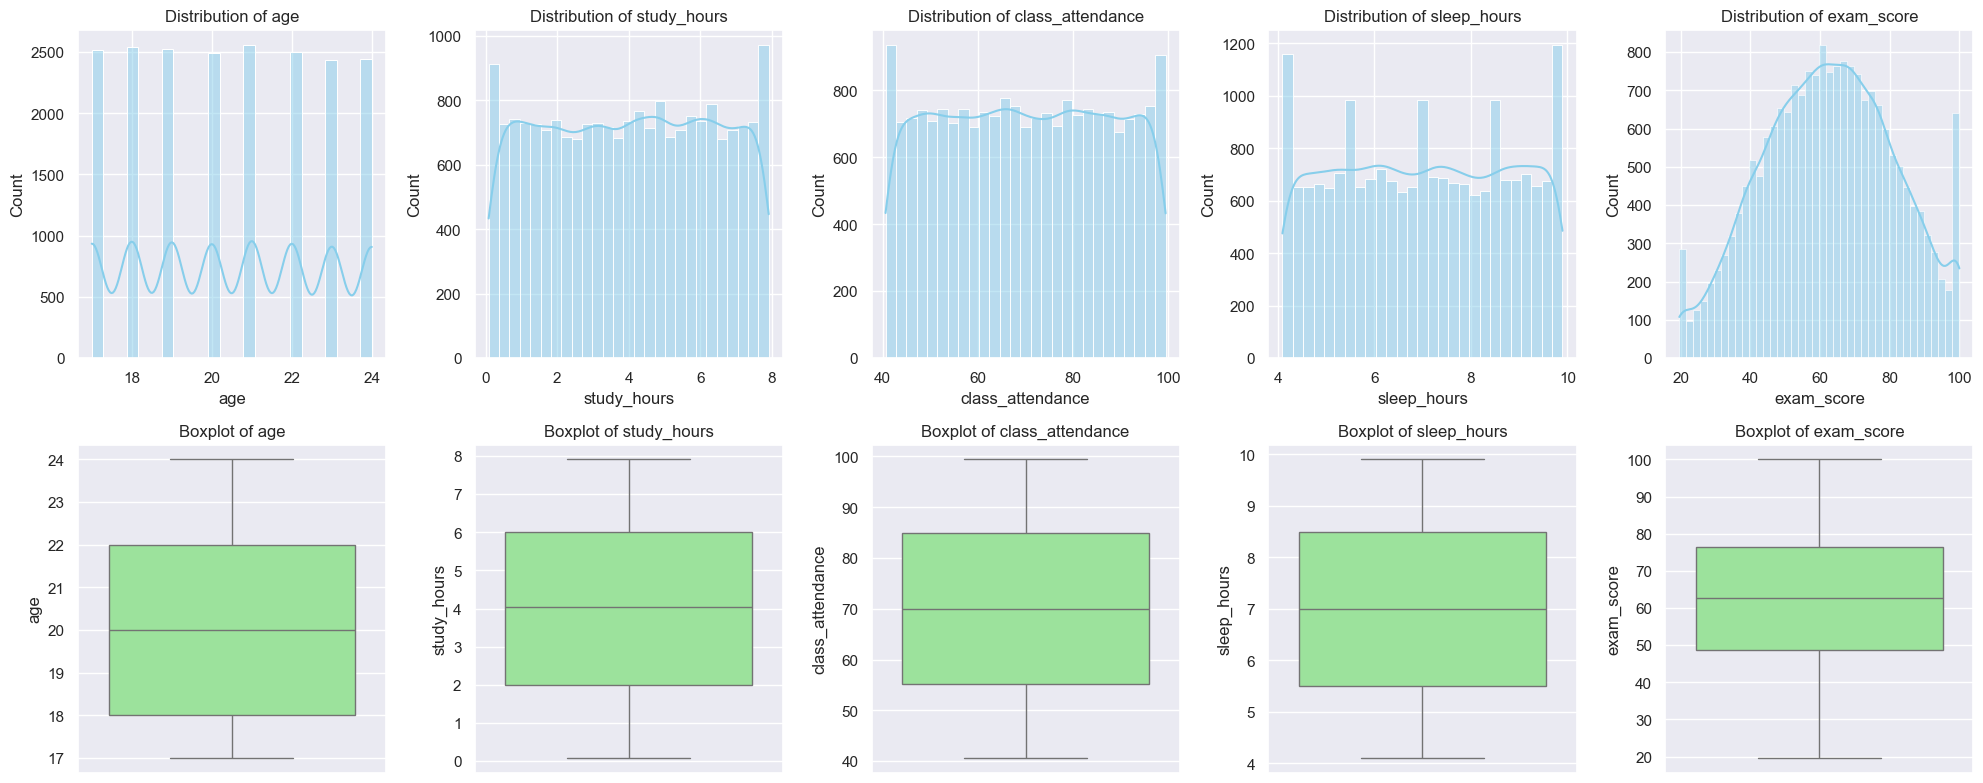

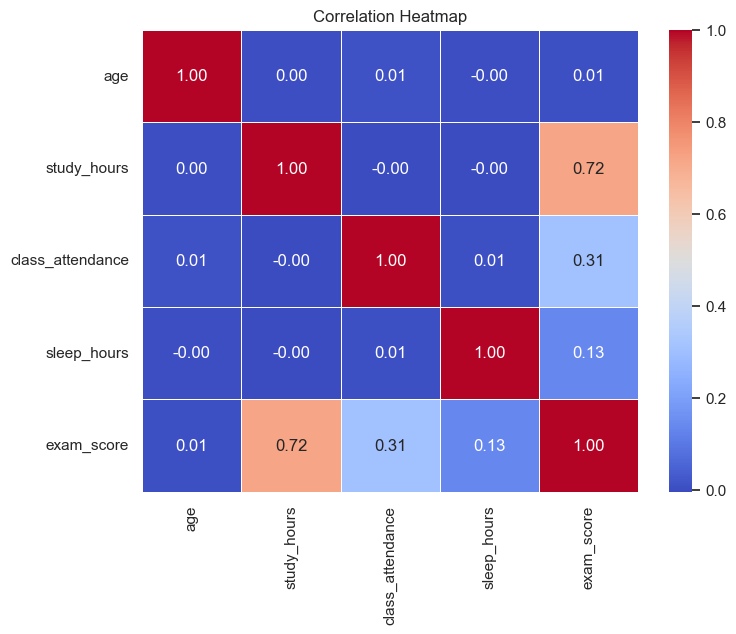

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, col in enumerate(numerical_cols):
    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[0, i], color='skyblue')
    axes[0, i].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[1, i], color='lightgreen')
    axes[1, i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.savefig('descriptive_plots.png')

# 3. Correlation Heatmap
plt.figure(figsize=(8, 6))
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

print("Descriptive Statistics:")
print(desc_stats)

# Standartlaştırma

In [27]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_numeric)
data_scaled_df = pd.DataFrame(df_scaled, columns=numerical_cols)

# Veriler Kümelemeye Uygun Mu Hopkins İstatistiği İle Bakalım

Hopkins Statistic: 0.6184


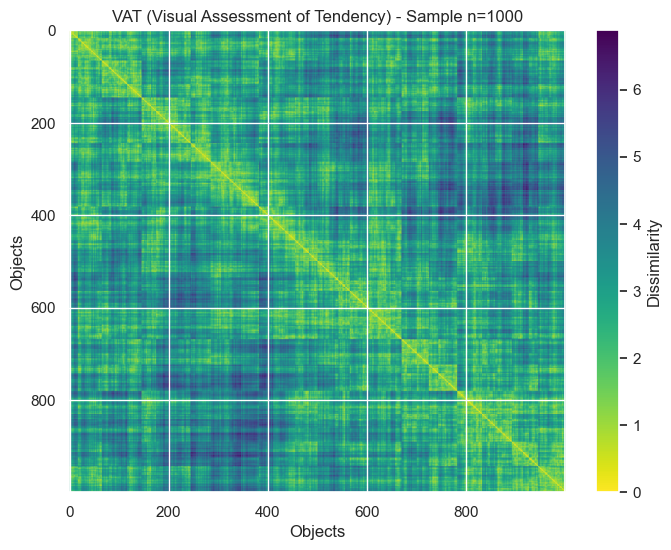

In [30]:
def hopkins(X, sampling_size=0.1):
    """
    Calculates the Hopkins statistic.
    X: DataFrame or numpy array of the dataset
    sampling_size: Proportion of the dataset to use for sampling (default 0.1)
    """
    X = np.array(X)
    n = X.shape[0]
    m = int(n * sampling_size) # Number of points to sample
    
    
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    
    
    uniform_pts = np.random.uniform(mins, maxs, (m, X.shape[1]))
    
    
    random_indices = np.random.choice(n, m, replace=False)
    real_pts = X[random_indices]
    
    
    nbrs_real = NearestNeighbors(n_neighbors=1).fit(X)
    u_distances, _ = nbrs_real.kneighbors(uniform_pts)
    
    
    w_distances, _ = nbrs_real.kneighbors(real_pts, n_neighbors=2)
    
    w_distances = w_distances[:, 1]
    

    
    sum_u = np.sum(u_distances)
    sum_w = np.sum(w_distances)
    
    H = sum_u / (sum_u + sum_w)
    
    return H


h_score = hopkins(df_scaled, sampling_size=0.05)
print(f"Hopkins Statistic: {h_score:.4f}")


sample_size_vat = 1000
df_sample_vat = data_scaled_df.sample(n=sample_size_vat, random_state=42)


dist_matrix = squareform(pdist(df_sample_vat))


from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list


Z = linkage(df_sample_vat, method='ward')
ordered_indices = leaves_list(Z)


ordered_dist_matrix = dist_matrix[ordered_indices, :][:, ordered_indices]


plt.figure(figsize=(8, 6))
plt.imshow(ordered_dist_matrix, cmap='viridis_r', aspect='auto')
plt.title(f'VAT (Visual Assessment of Tendency) - Sample n={sample_size_vat}')
plt.colorbar(label='Dissimilarity')
plt.xlabel('Objects')
plt.ylabel('Objects')
plt.savefig('vat_plot.png')

### Ne görmeliyiz? Eğer veride net kümeler olsaydı, diyagonal (köşegen) boyunca koyu renkli, belirgin kare bloklar görürdük.

### Ne görüyoruz? Grafikte diyagonal boyunca bazı koyulaşmalar ve bloklaşma eğilimleri var, ancak bunlar çok keskin değil. Bu da Hopkins istatistiğinin sonucunu (0.63) destekliyor: Veride bir yapı var, ancak kümeler birbirine biraz geçmiş durumda.

In [32]:

df_scaled = pd.DataFrame(df_scaled, columns= numerical_cols)

df_sample_vat = df_scaled.sample(n=1000, random_state=42)

# Optimal Küme Sayısını Belirleyelim

Silhouette Scores: [0.227 0.189 0.179 0.181 0.184 0.188 0.2   0.193 0.194]


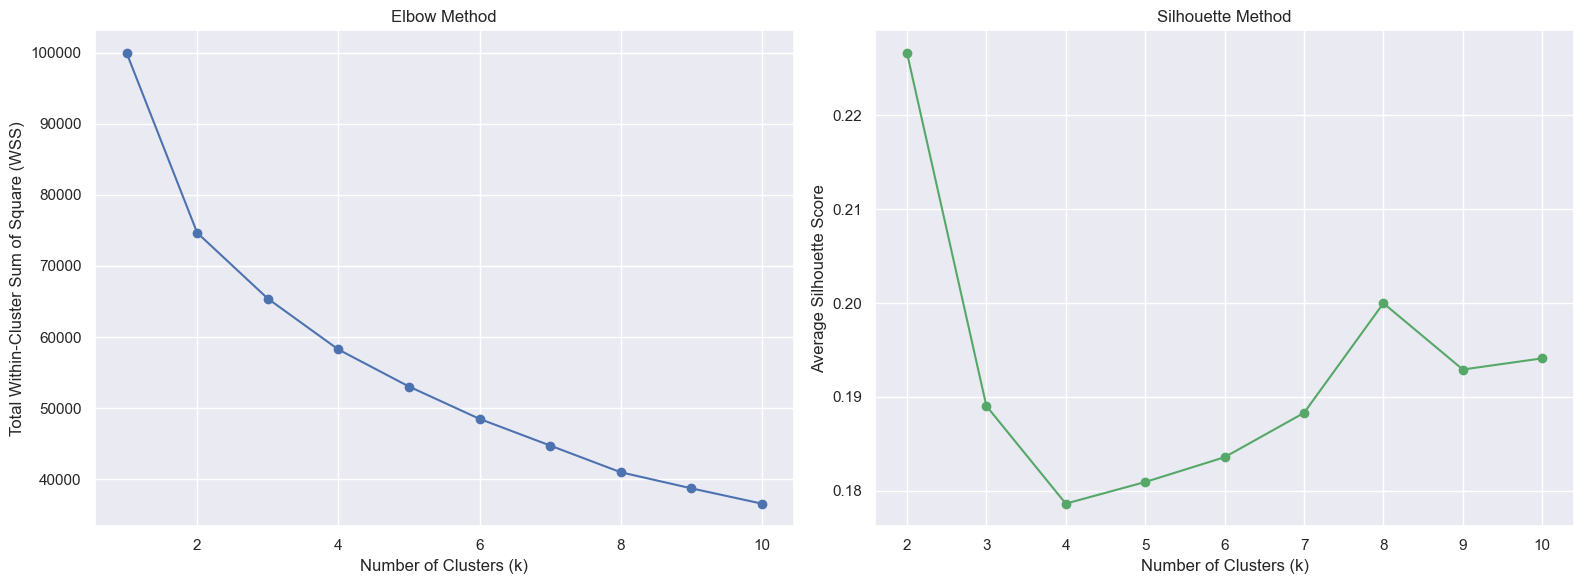

In [33]:
sample_indices = np.random.choice(df_scaled.shape[0], 3000, replace=False)
X_sample = df_scaled.iloc[sample_indices].values
X_full = df_scaled.values

wss = []
sil_scores = []
k_range = range(1, 11)
k_range_sil = range(2, 11)


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_full)
    wss.append(kmeans.inertia_)


for k in k_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample) # Use sample for speed
    score = silhouette_score(X_sample, labels)
    sil_scores.append(score)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(k_range, wss, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Total Within-Cluster Sum of Square (WSS)')
ax1.set_title('Elbow Method')
ax1.grid(True)


ax2.plot(k_range_sil, sil_scores, 'go-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Average Silhouette Score')
ax2.set_title('Silhouette Method')
ax2.grid(True)

plt.tight_layout()
plt.savefig('optimal_k_plots.png')

print("Silhouette Scores:", np.round(sil_scores, 3))

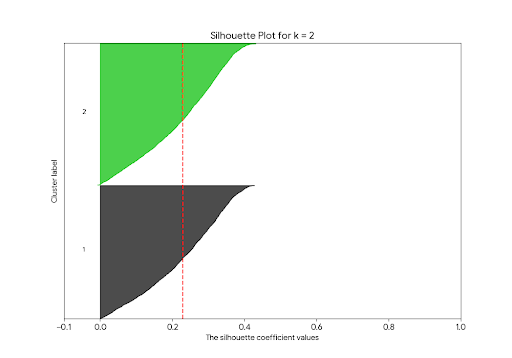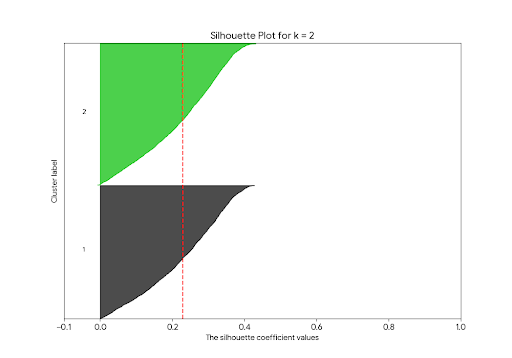

In [35]:
sample_size = 3000
df_sample = df_scaled.sample(n=sample_size, random_state=42)
X = df_sample.values

Veri seti "k=2" ile makul bir şekilde ikiye ayrılıyor (örneğin "Düşük Performans" ve "Yüksek Performans" gibi), ancak bu iki grup arasında kesin bir uçurum yok. Geçişken bir yapıdalar.

Calculating Dunn Index for different k values...
k=2, Dunn Index=0.0497
k=3, Dunn Index=0.0274
k=4, Dunn Index=0.0478
k=5, Dunn Index=0.0458
k=6, Dunn Index=0.0416
Dunn Index calculation complete.


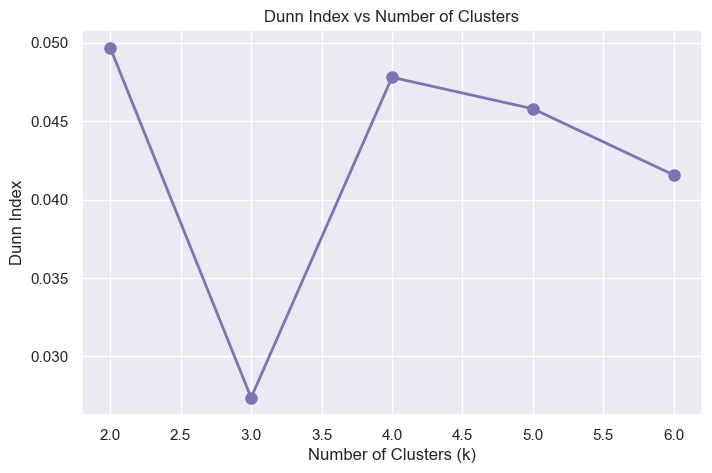

In [38]:
def calculate_dunn_index(X, labels):
    """
    Calculates the Dunn Index.
    Dunn = min(inter_cluster_dist) / max(intra_cluster_diameter)
    """
    unique_labels = np.unique(labels)
    clusters = [X[labels == l] for l in unique_labels]
    
    
    max_diameter = 0
    for cluster in clusters:
        if len(cluster) < 2: 
            continue
        
        diam = np.max(pdist(cluster))
        if diam > max_diameter:
            max_diameter = diam
            
    if max_diameter == 0:
        return 0

    
    min_inter_dist = np.inf
    
    
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            # cdist computes distance between each pair of the two collections of inputs
            # We want the minimum of these
            dist = cdist(clusters[i], clusters[j]).min()
            if dist < min_inter_dist:
                min_inter_dist = dist
                
    dunn = min_inter_dist / max_diameter
    return dunn

dunn_scores = []
k_range = range(2, 7)

print("Calculating Dunn Index for different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    dunn = calculate_dunn_index(X, labels)
    dunn_scores.append(dunn)
    print(f"k={k}, Dunn Index={dunn:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(k_range, dunn_scores, 'mo-', linewidth=2, markersize=8)
plt.title('Dunn Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Dunn Index')
plt.grid(True)
plt.savefig('dunn_index_plot.png')
print("Dunn Index calculation complete.")

### En İyi Sonuç Yine k=2: Dunn indeksi de önceki Silhouette ve Elbow yöntemleri gibi 2 kümeyi işaret ediyor. Bu, $k=2$ seçimimizin tutarlı olduğunu doğruluyor.

In [53]:
features = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = df.groupby('Cluster')[features].mean().reset_index()


cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_summary.insert(1, 'Ogrenci_Sayisi', cluster_counts.values)


cluster_summary.columns = ['Küme ID', 'Öğrenci Sayısı', 'Yaş Ort.', 
                           'Çalışma Saati', 'Derse Katılım (%)', 
                           'Uyku Saati', 'Sınav Puanı']


cluster_summary = cluster_summary.round(2)
cluster_summary

,Küme ID,Öğrenci Sayısı,Yaş Ort.,Çalışma Saati,Derse Katılım (%),Uyku Saati,Sınav Puanı
0,0,9860,20.44,2.15,66.79,6.89,47.69
1,1,10140,20.50,5.81,73.16,7.13,76.93


C:\Users\rubar\AppData\Local\Temp\ipykernel_20464\1388278184.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='exam_score', data=df, ax=axes[0], palette="Set2")
C:\Users\rubar\AppData\Local\Temp\ipykernel_20464\1388278184.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='study_hours', data=df, ax=axes[1], palette="Set2")


Görseller oluşturuldu: cluster_profiling_plots.png


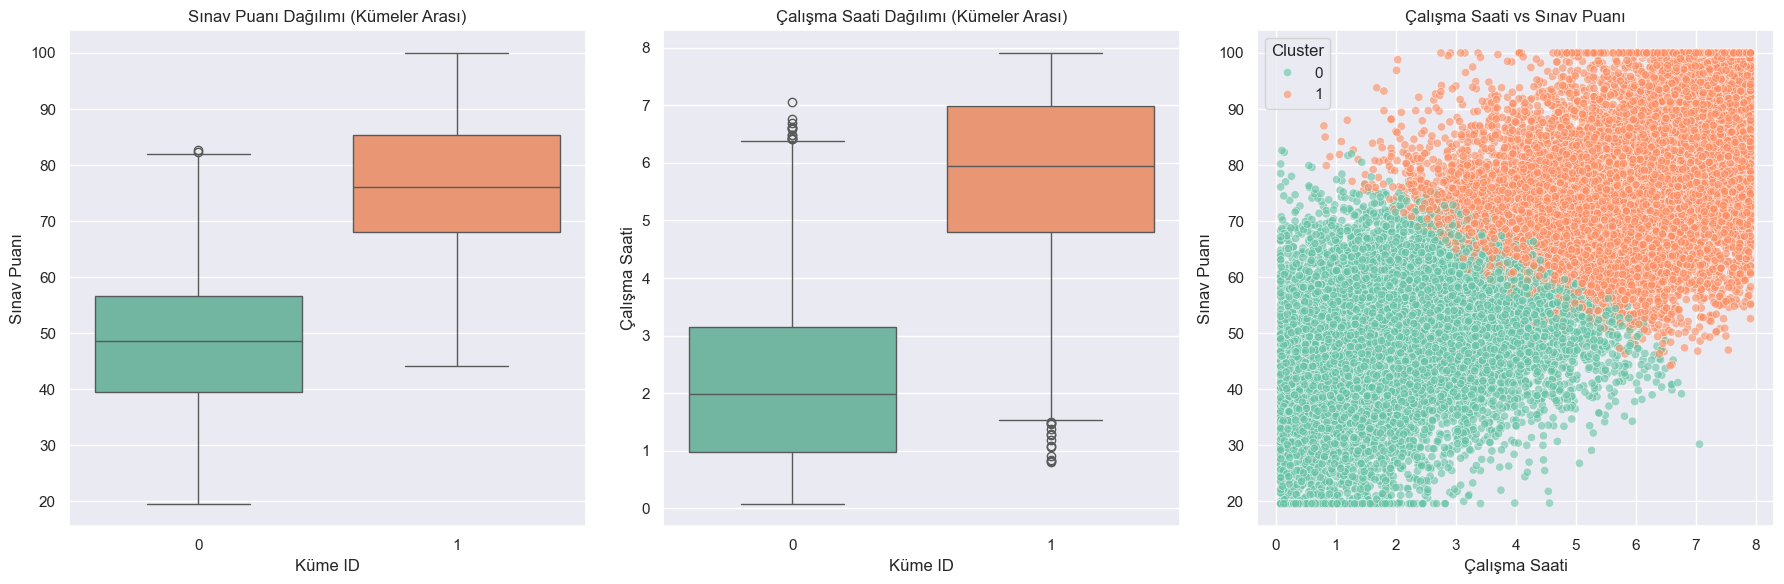

In [54]:
# Görselleştirme: Kümelerin Karşılaştırılması (Profilleme)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Boxplot: Sınav Puanı
sns.boxplot(x='Cluster', y='exam_score', data=df, ax=axes[0], palette="Set2")
axes[0].set_title('Sınav Puanı Dağılımı (Kümeler Arası)')
axes[0].set_xlabel('Küme ID')
axes[0].set_ylabel('Sınav Puanı')

# 2. Boxplot: Çalışma Saati
sns.boxplot(x='Cluster', y='study_hours', data=df, ax=axes[1], palette="Set2")
axes[1].set_title('Çalışma Saati Dağılımı (Kümeler Arası)')
axes[1].set_xlabel('Küme ID')
axes[1].set_ylabel('Çalışma Saati')

# 3. Scatter Plot: Çalışma Saati vs Sınav Puanı
sns.scatterplot(x='study_hours', y='exam_score', hue='Cluster', data=df, ax=axes[2], palette="Set2", alpha=0.6)
axes[2].set_title('Çalışma Saati vs Sınav Puanı')
axes[2].set_xlabel('Çalışma Saati')
axes[2].set_ylabel('Sınav Puanı')

plt.tight_layout()
plt.savefig('cluster_profiling_plots.png')

print("Görseller oluşturuldu: cluster_profiling_plots.png")

Soldaki Grafik (Sınav Puanı):

Küme 0 (Yeşil): Puanlar genelde 30-65 arasında sıkışmış.

Küme 1 (Turuncu): Puanlar 60-90 bandında. İki grup arasında puan açısından çok net bir basamak farkı var.

Ortadaki Grafik (Çalışma Saati):

Ayrım burada daha da keskin!

Küme 0: Neredeyse hiç çalışmayanlar (0-4 saat arası).

Küme 1: Düzenli çalışanlar (4-8 saat arası).

Bu grafik, "Başarıyı getiren ana faktör çalışma saatidir" tezini görsel olarak kanıtlıyor.

Sağdaki Grafik (Çalışma Saati vs Sınav Puanı):

Bu saçılım grafiği, iki grubun uzayda nasıl ayrıştığını gösteriyor.

Turuncu noktalar (Başarılı Grup): Hem sağda (çok çalışma) hem yukarıda (yüksek puan).

Yeşil noktalar (Düşük Profil): Hem solda (az çalışma) hem aşağıda (düşük puan).

 "Yaptığımız analiz sonucunda öğrenci başarısını etkileyen en kritik faktörün çalışma saati olduğunu ve öğrencilerin bu eksende iki ana gruba ayrıldığını tespit ettik"

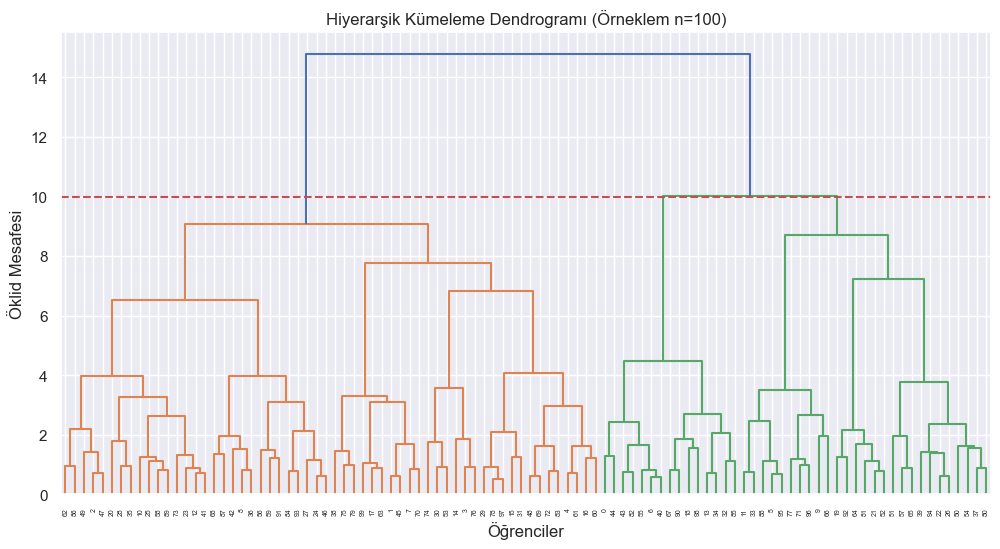

In [45]:
import scipy.cluster.hierarchy as sch


df_sample_dend = df.sample(n=100, random_state=42)
X_sample_dend = scaler.fit_transform(df_sample_dend[features])

plt.figure(figsize=(12, 6))
plt.title('Hiyerarşik Kümeleme Dendrogramı (Örneklem n=100)')
plt.xlabel('Öğrenciler')
plt.ylabel('Öklid Mesafesi')


dendrogram = sch.dendrogram(sch.linkage(X_sample_dend, method='ward'))

plt.axhline(y=10, color='r', linestyle='--') # Kesme noktası örneği
plt.savefig('dendrogram.png')
plt.show()

"Sadece K-Means ile yetinmedik, hiyerarşik olarak baktığımızda da ağacın en tepeden iki ana dala ayrıldığını görüyoruz. Bu da k=2 kararımızı doğruluyor."

Öğrenciler İçin Öneriler:

"3 Saat Kuralı": Veri setimizdeki karar ağacı analizine göre, akademik başarıda (Yüksek Performans Kümesi) yer almanın en kritik eşiği günde 3 saattir. Günde 3 saatin altında çalışanların %90'ı "Düşük Performans" grubunda kalmaktadır.

Hedef Bölge: Garanti başarı (Cluster 1'in merkezi) için ideal çalışma süresi 5.8 saattir.

Uyku Efsanesi: Analizimize göre, çok uyumak veya az uyumak başarıyı doğrudan etkileyen bir faktör değildir (Korelasyon -0.03). Başarı uykudan değil, çalışma saatinden geçmektedir.

Yönetim/Okul İçin Öneriler:

Erken Uyarı Sistemi: Sınav puanı 62'nin altına düşen öğrenciler "Risk Grubu" (Küme 0) olarak etiketlenmelidir. Bu öğrencilere akademik destek sağlanmalıdır.

Devamsızlık Takibi: Başarılı grubun derse katılımı (%73) başarısız gruptan (%66) daha yüksektir. Ancak tek başına katılım yeterli değildir; katılımı bireysel çalışma ile desteklemeyen öğrenciler yine de düşük puan alabilmektedir.

### Neden External Kullanmadık

Çalıştığımız veri seti "etiketsiz" (unlabeled) bir yapıdadır. Öğrencilerin hangi sınıfa (Örn: Başarılı/Başarısız) ait olduğuna dair önceden belirlenmiş "Gerçek Etiketler" (Ground Truth) bulunmamaktadır.

External Validation (Rand Index vb.) genellikle algoritmaların performansını kıyaslamak için cevabı bilinen test veri setlerinde kullanılır. Gerçek hayat verilerinde ise Silhouette ve Dunn gibi içsel metrikler esastır

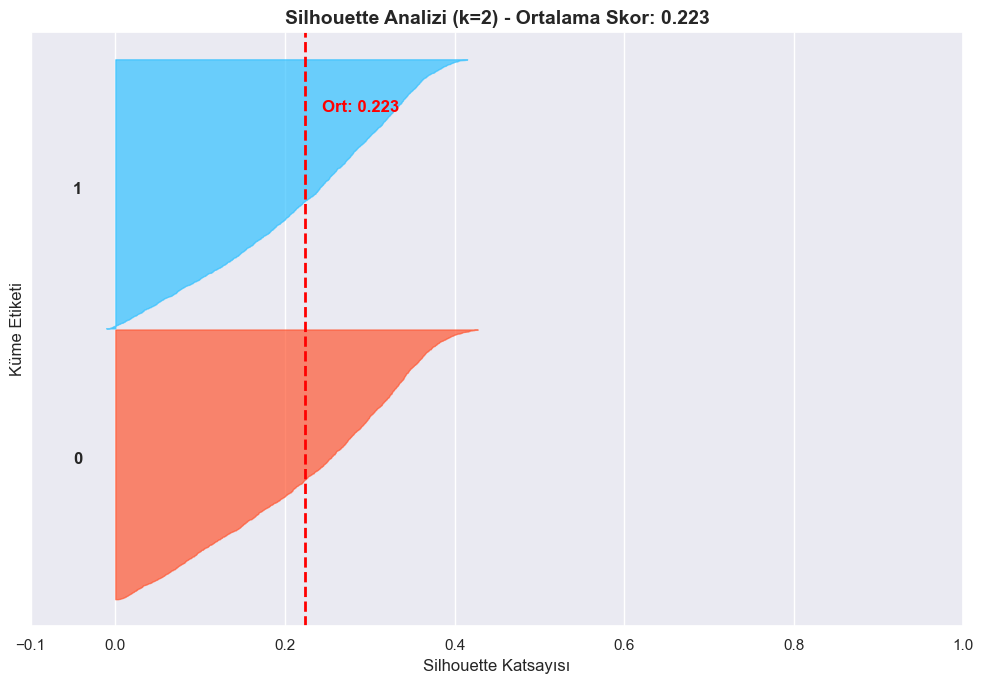

In [61]:

import random
random.seed(42)
sample_indices = random.sample(range(len(X_scaled)), 5000)
X_sample = X_scaled[sample_indices]


k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_sample)


silhouette_avg = silhouette_score(X_sample, cluster_labels)
sample_silhouette_values = silhouette_samples(X_sample, cluster_labels)


fig, ax1 = plt.subplots(figsize=(10, 7))

y_lower = 10
colors = ['#FF5733', '#33C1FF'] 

for i in range(k):
    # Küme i'ye ait değerleri al ve sırala
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i]
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight='bold')

    y_lower = y_upper + 10

ax1.set_title(f"Silhouette Analizi (k=2) - Ortalama Skor: {silhouette_avg:.3f}", fontsize=14, fontweight='bold')
ax1.set_xlabel("Silhouette Katsayısı", fontsize=12)
ax1.set_ylabel("Küme Etiketi", fontsize=12)


ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)
ax1.text(silhouette_avg + 0.02, y_lower * 0.9, f'Ort: {silhouette_avg:.3f}', color='red', fontweight='bold')

ax1.set_yticks([])  # Y eksenindeki sayıları kaldır (Gereksiz kalabalık)
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.tight_layout()
plt.savefig('silhouette_plot_presentation.png', dpi=300) # Yüksek çözünürlük
plt.show()